In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from scipy.stats import mode

from scipy.stats import f_oneway, chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

from sklearn.decomposition import PCA

## Preparing Data

In [ ]:
# Read CSV file
df_raw = pd.read_csv('diabetes_dataset_nan.csv')
df_raw.head()

,Unnamed: 0,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,1,48,Female,White,Highschool,Middle,Employed,Former,1,143,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,3,74,Female,Black,Highschool,Low,NaN,Never,0,49,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,4,46,Male,White,Graduate,Middle,Retired,Never,1,109,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [ ]:
df_raw.dtypes

Unnamed: 0                              int64
age                                     int64
gender                                 object
ethnicity                              object
education_level                        object
income_level                           object
employment_status                      object
smoking_status                         object
alcohol_consumption_per_week            int64
physical_activity_minutes_per_week      int64
diet_score                            float64
sleep_hours_per_day                   float64
screen_time_hours_per_day             float64
family_history_diabetes               float64
hypertension_history                    int64
cardiovascular_history                  int64
bmi                                   float64
waist_to_hip_ratio                    float64
systolic_bp                             int64
diastolic_bp                            int64
heart_rate                              int64
cholesterol_total                 

In [ ]:
# Convert 0/1 numerical codes into categorical labels ("No"/"Yes")
df_raw['family_history_diabetes'] = df_raw['family_history_diabetes'].replace({0: 'No', 1: 'Yes'})
df_raw['hypertension_history'] = df_raw['hypertension_history'].replace({0: 'No', 1: 'Yes'})
df_raw['cardiovascular_history'] = df_raw['cardiovascular_history'].replace({0: 'No', 1: 'Yes'})
df_raw['diagnosed_diabetes'] = df_raw['diagnosed_diabetes'].replace({0: 'No', 1: 'Yes'})

# Replace "Unknown" gender by "Other" and set as categorical
df_raw['gender'] = df_raw['gender'].replace({"Unknown": 'Other'})

# Replace invalid BMI values (0) by NaN
df_raw['bmi'] = df_raw['bmi'].replace({0: np.nan})

In [ ]:
# --- Identify types of features in the dataset ---
# Select columns with categorical data (dtype = object)
categoric_features = df_raw.select_dtypes(include=['object']).columns
# Select columns with discrete numeric data (dtype = int64)
numeric_descrete_features = df_raw.select_dtypes(include=['int64']).columns
# Select columns with continuous numeric data (dtype = float64)
numeric_continuous_features = df_raw.select_dtypes(include=['float64']).columns

print(f"Number of categoric features: {len(categoric_features)}")
print("Categoric features:", list(categoric_features))

print(f"\nNumber of numeric features: {len(numeric_descrete_features) + len(numeric_continuous_features)}")
print("Numeric features:", list(numeric_descrete_features) + list(numeric_continuous_features))

# --- Identify features with missing values ---
features_with_nas = df_raw.isna().sum()
features_with_nas = features_with_nas[features_with_nas > 0]

print("\nFeatures with missing values:")
print(features_with_nas)

Number of categoric features: 11
Categoric features: ['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 'smoking_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'diabetes_stage', 'diagnosed_diabetes']

Number of numeric features: 21
Numeric features: ['Unnamed: 0', 'age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'insulin_level', 'hba1c', 'diabetes_risk_score']

Features with missing values:
employment_status          10000
family_history_diabetes    10000
bmi                        10000
dtype: int64


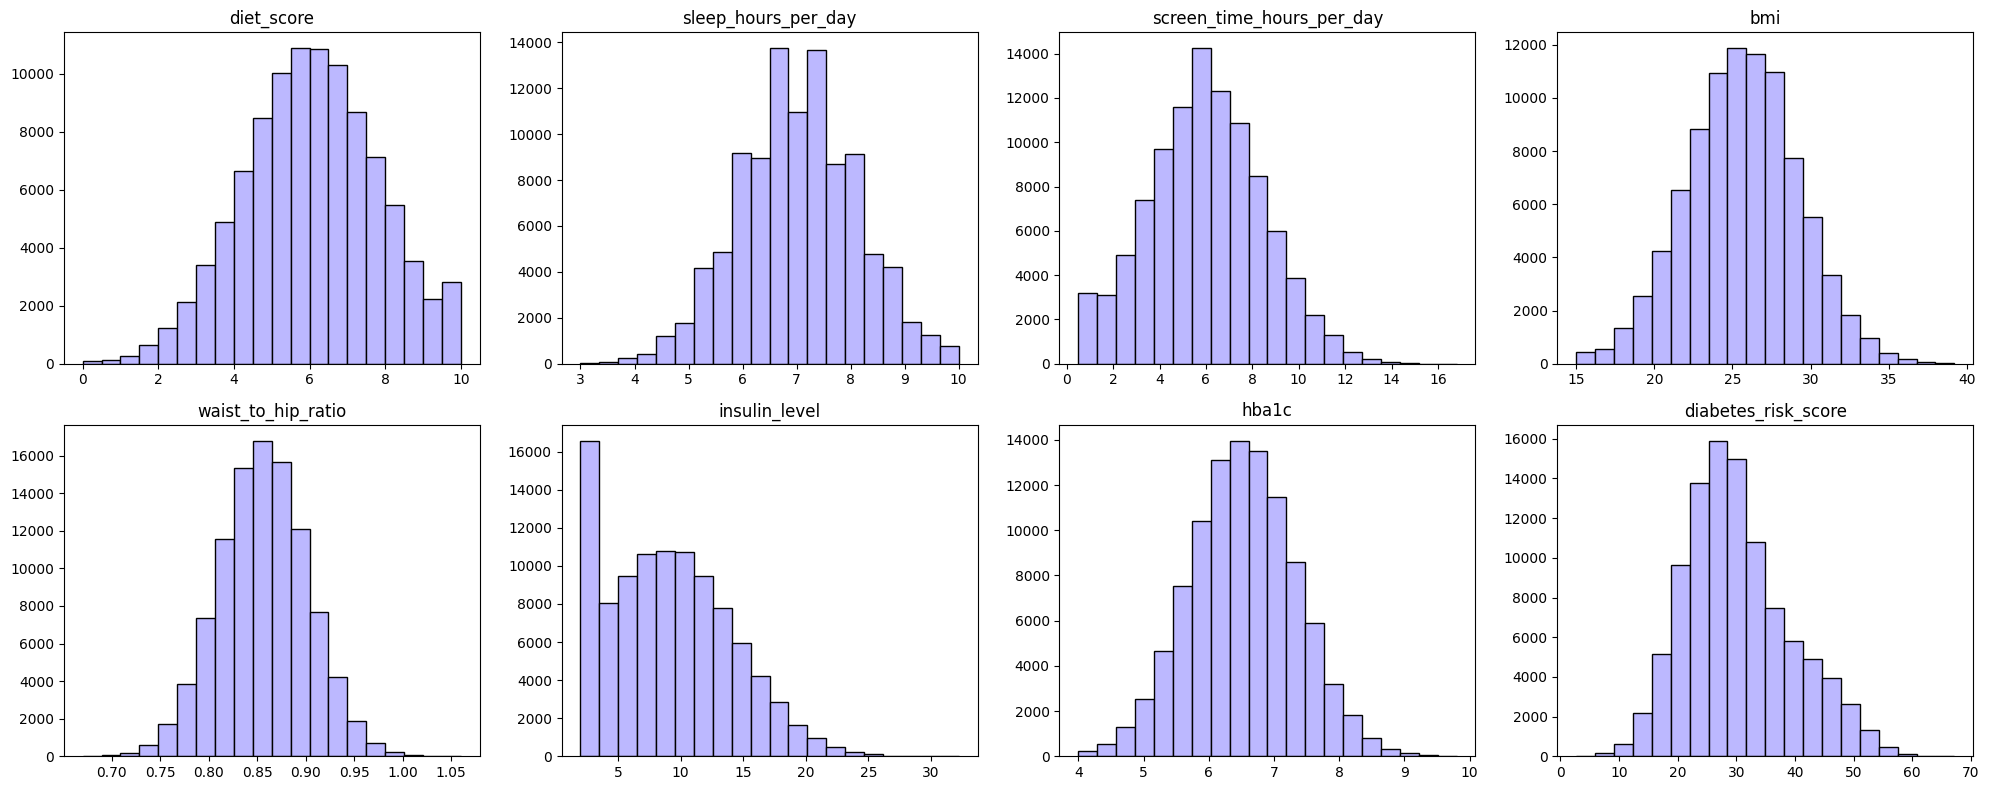

In [ ]:
# --- Visualize the distribution of continuous numeric features ---

n_num = len(numeric_continuous_features)
if n_num > 0:
    n_cols = 4
    n_rows = math.ceil(n_num / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    # Loop through each continuous feature and plot a histogram
    for i, col in enumerate(numeric_continuous_features):
        # Plot histogram of the feature, excluding NaN values
        axes[i].hist(df_raw[col].dropna(), bins=20, color='#BCB8FF', edgecolor='black')
        axes[i].set_title(f'{col}')

    # Remove any empty subplots (if number of features < grid cells)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

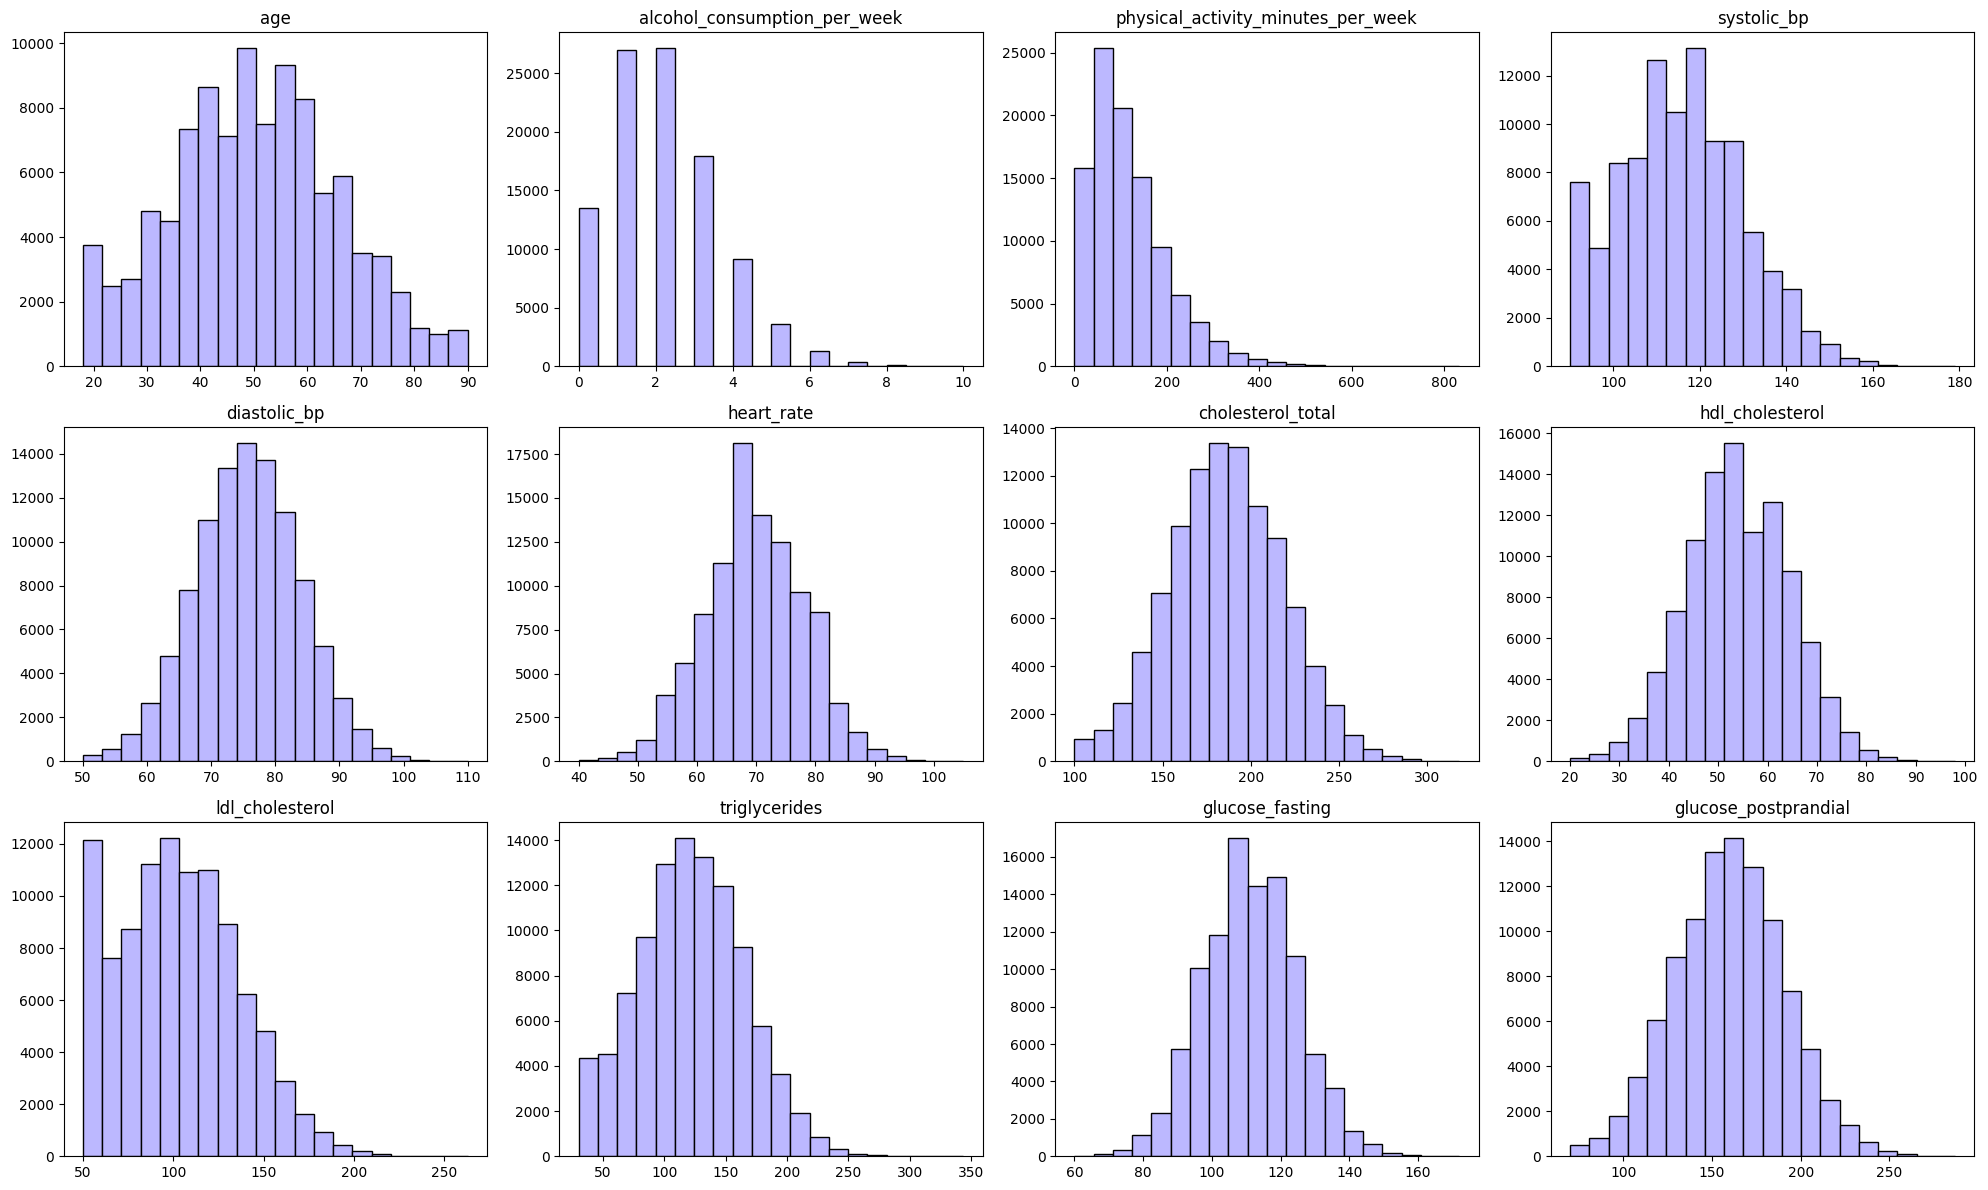

In [ ]:
# --- Visualize the distribution of descrete numeric features ---

n_num = len(numeric_descrete_features[1:])
if n_num > 0:
    n_cols = 4
    n_rows = math.ceil(n_num / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    # Loop through each descrete feature and plot a histogram
    for i, col in enumerate(numeric_descrete_features[1:]):
        axes[i].hist(df_raw[col].dropna(), bins=20, color='#BCB8FF', edgecolor='black')
        axes[i].set_title(f'{col}')

    # Remove any empty subplots (if number of features < grid cells)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

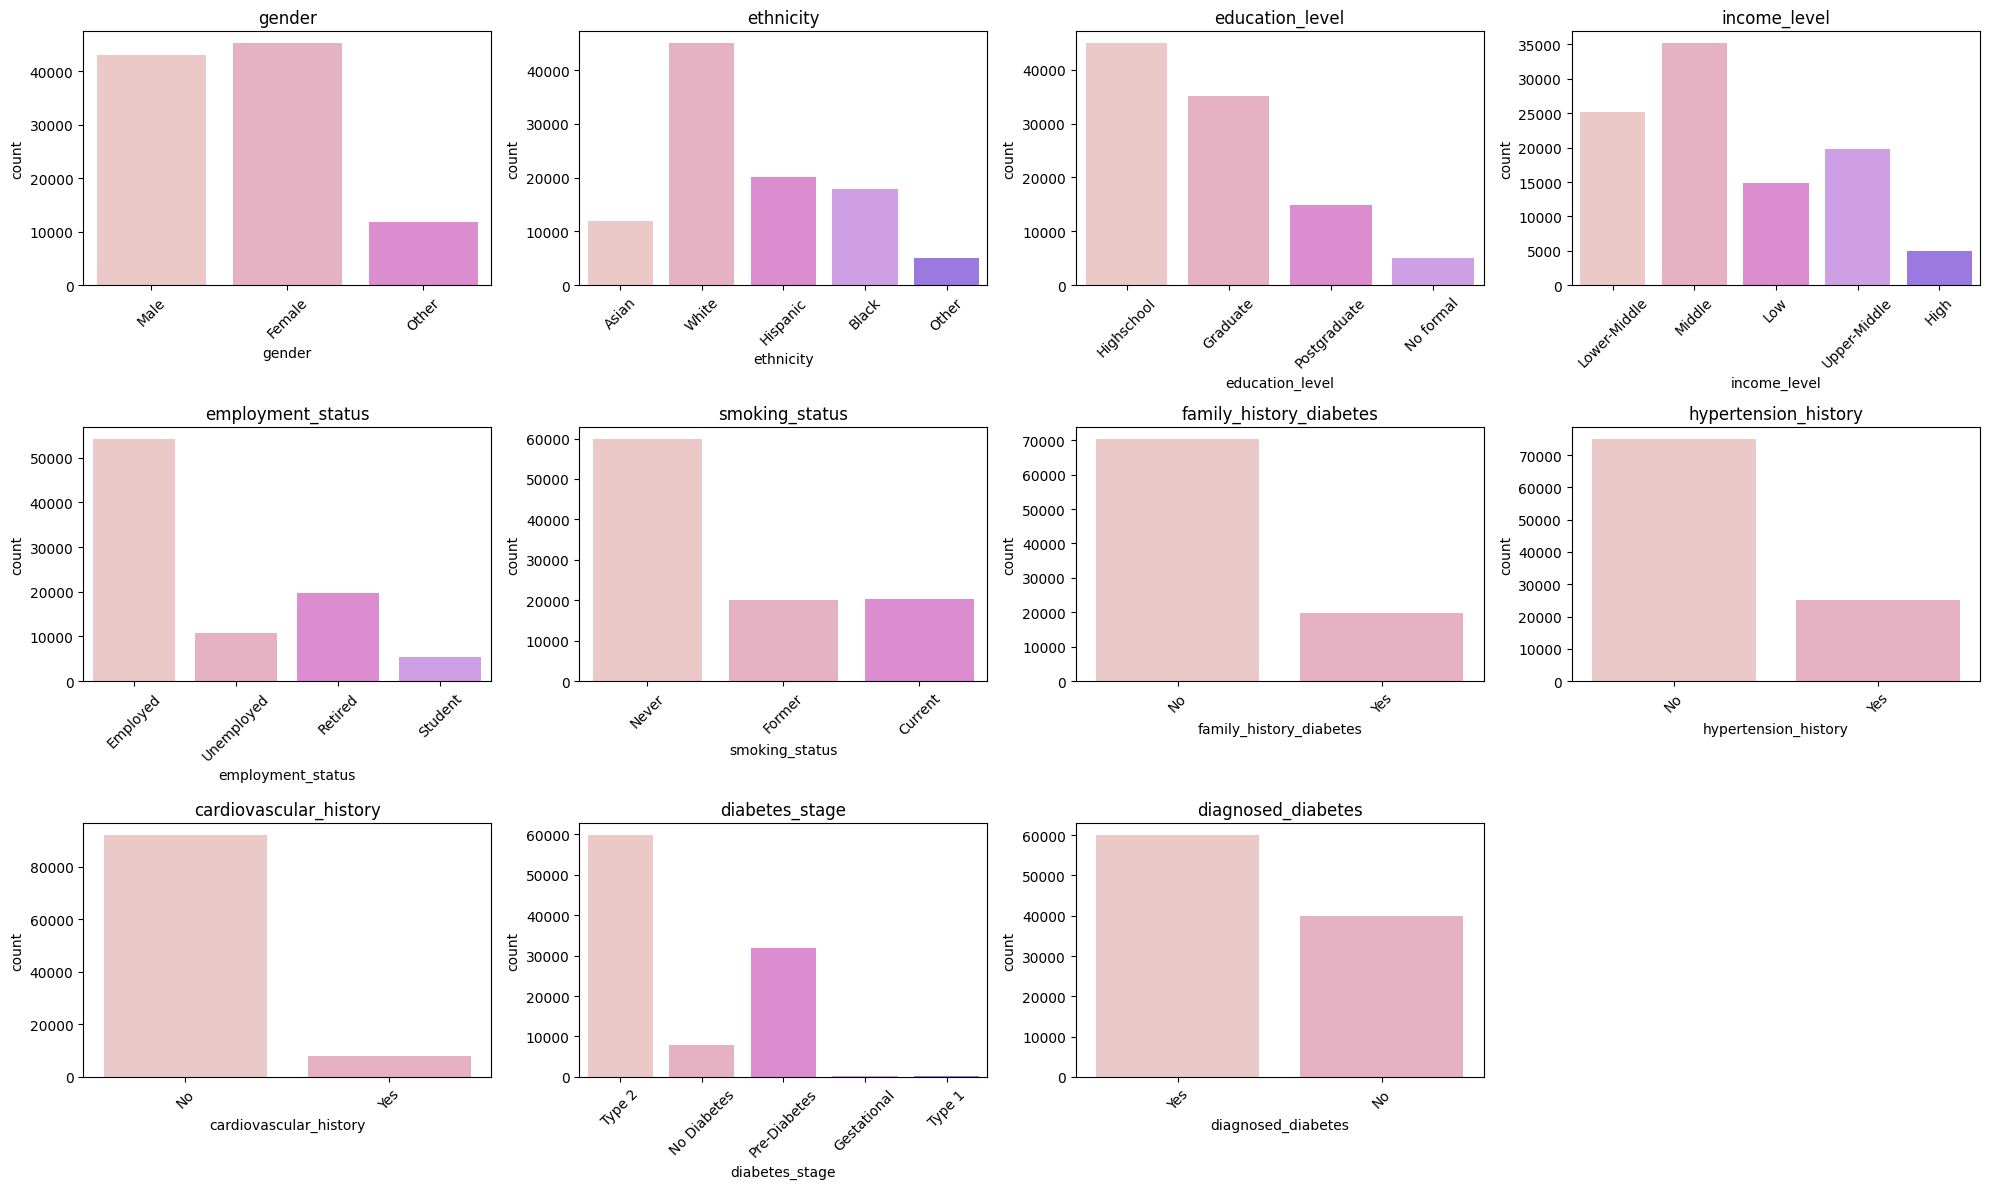

In [ ]:
# --- Bar plots for categorical features ---

n_cat = len(categoric_features)
palette_colors = ["#F1C3C2","#EFA8C0", "#E980D9", "#D293F0", "#9668F1"]

if n_cat > 0:
    n_cols = 4
    n_rows = math.ceil(n_cat / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    # Loop through each categorical feature and plot its distribution
    for i, col in enumerate(categoric_features):
        # Create a bar plot showing the frequency of each category
        num_classes = df_raw[col].nunique()
        sns.countplot(x=df_raw[col], hue=df_raw[col], ax=axes[i], palette=palette_colors[:num_classes], legend=False)
        axes[i].set_title(f'{col}')
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Imputation

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw[list(numeric_descrete_features[1:]) + list(numeric_continuous_features)])
df_scaled = pd.DataFrame(df_scaled, columns=list(numeric_descrete_features[1:]) + list(numeric_continuous_features))

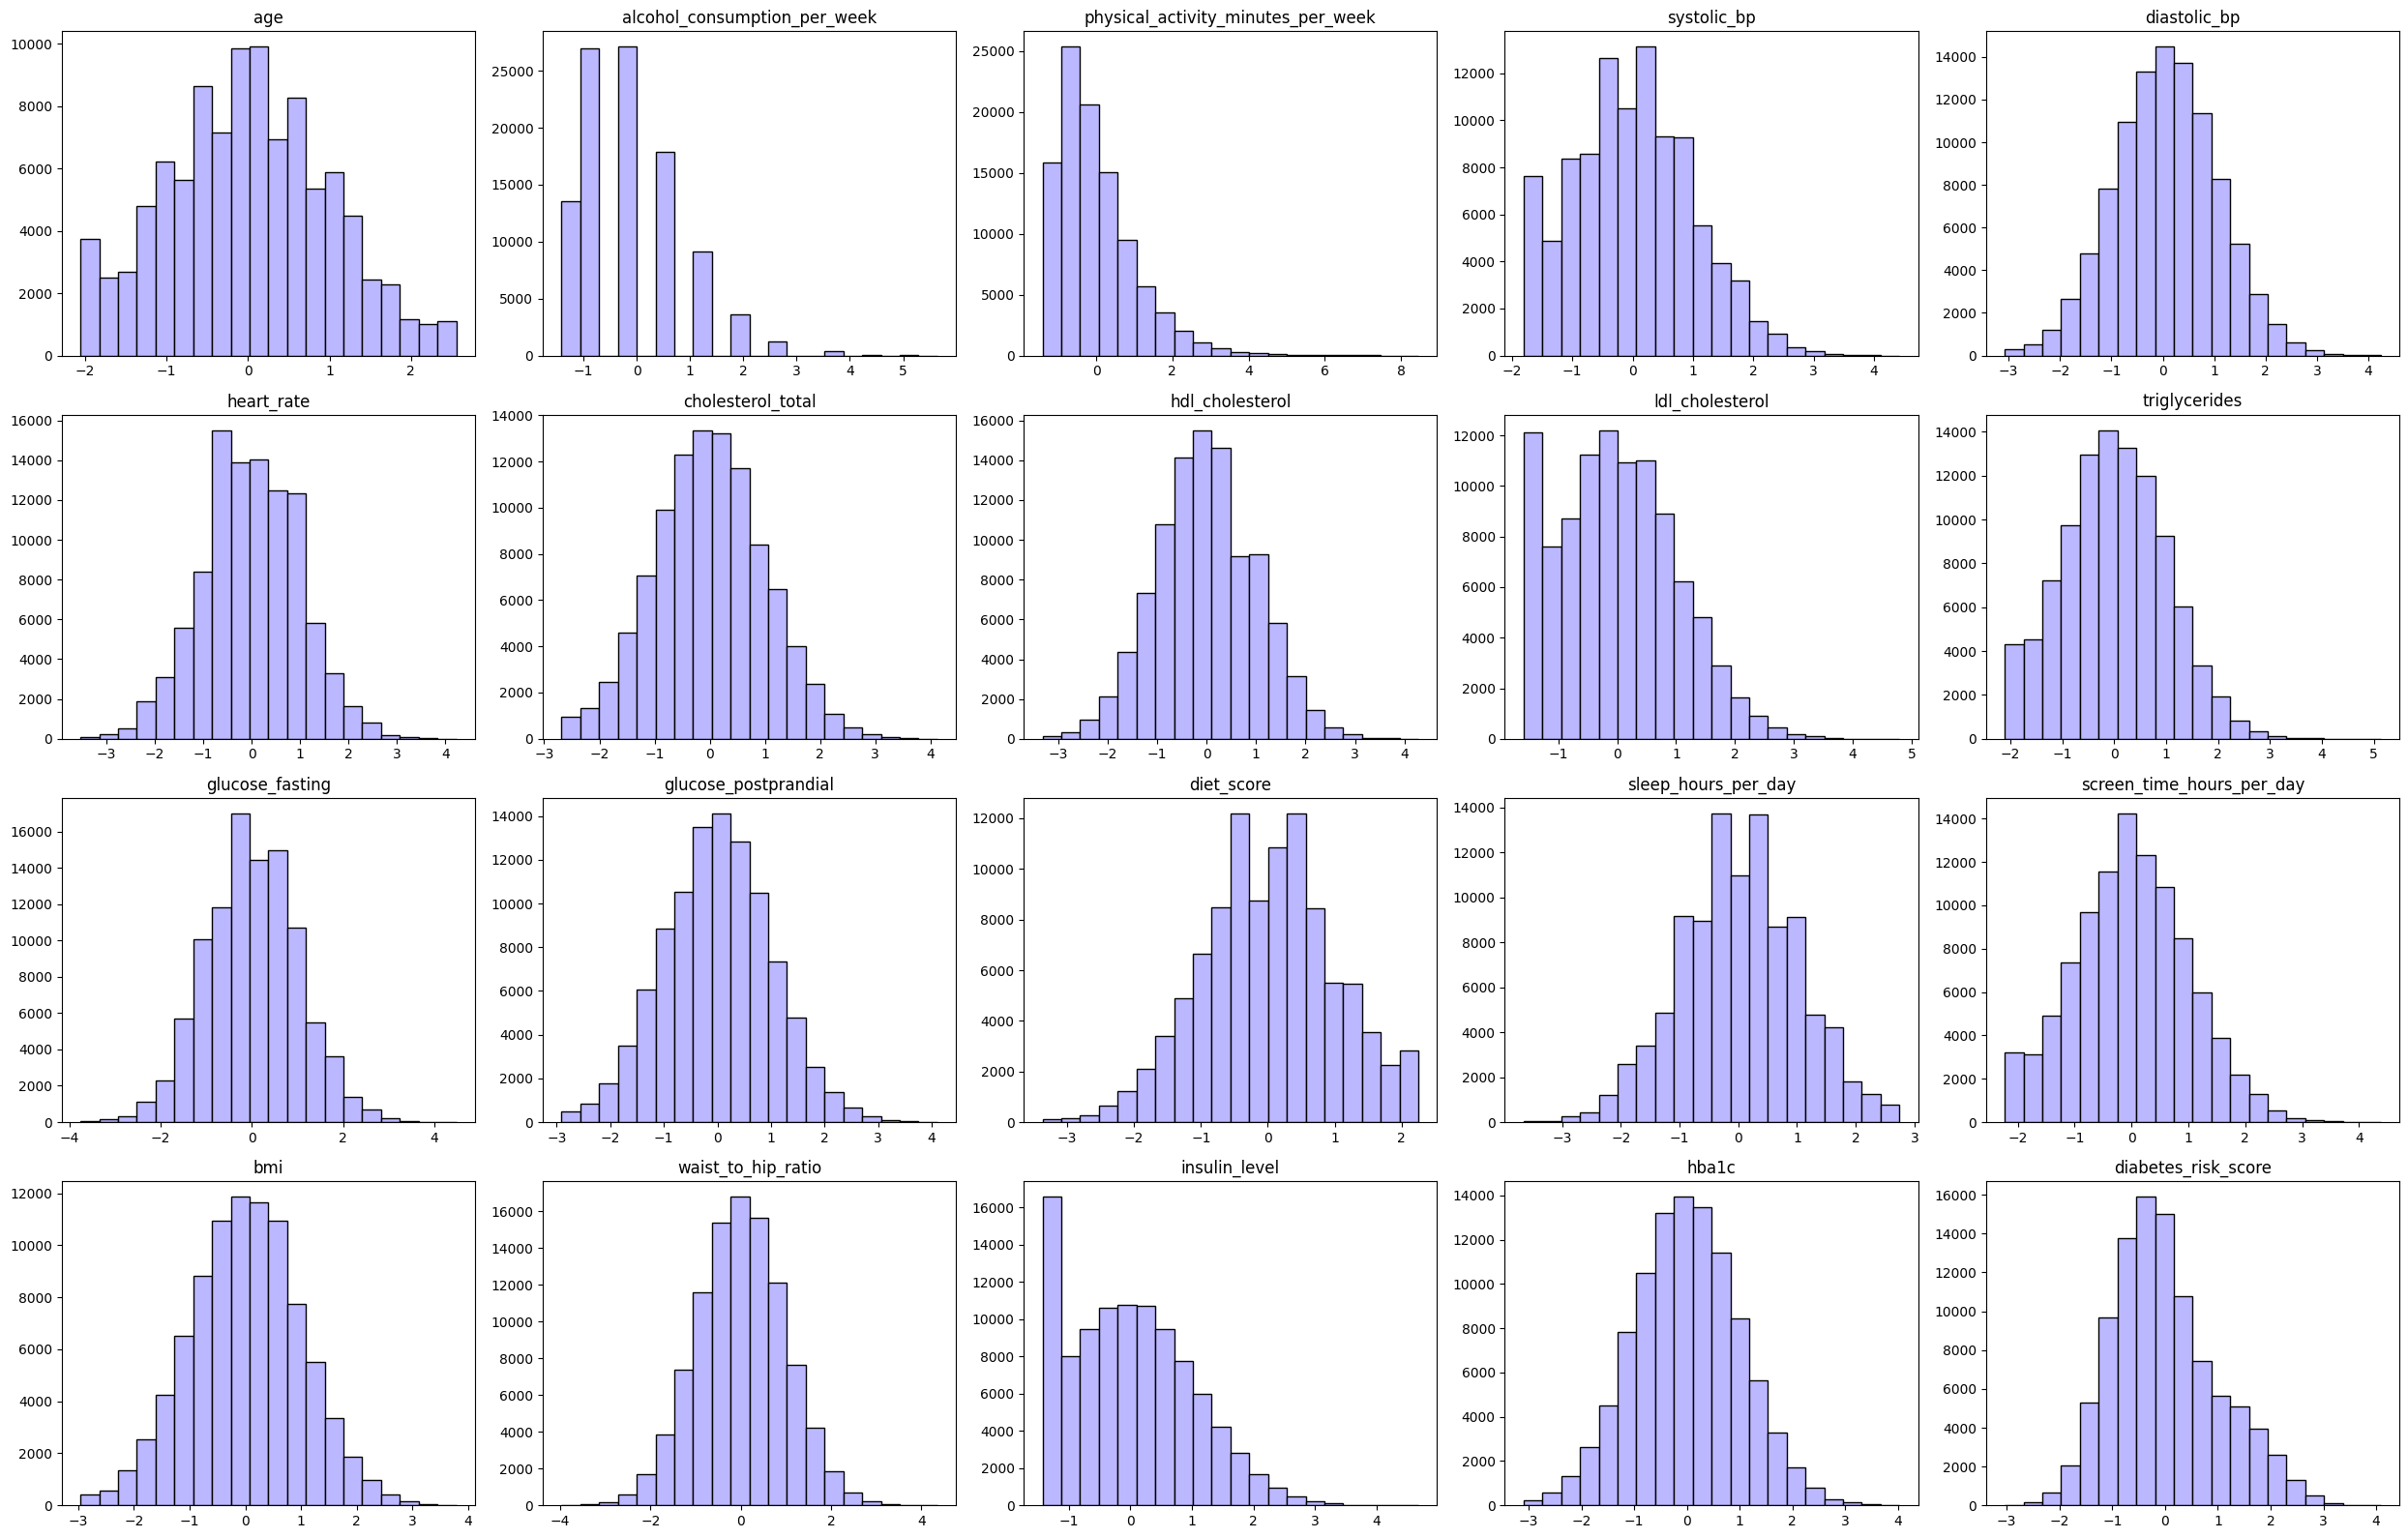

In [ ]:
# --- Visualize the distribution of all scaled numerical features ---

n_num = len(df_scaled.columns)
if n_num > 0:
    n_cols = 5
    n_rows = math.ceil(n_num / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(df_scaled.columns):
        axes[i].hist(df_scaled[col].dropna(), bins=20, color='#BCB8FF', edgecolor='black')
        axes[i].set_title(f'{col}')

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
imputer = KNNImputer(n_neighbors=5)
df_imputed = imputer.fit_transform(df_scaled)
df_imputed_num = pd.DataFrame(df_imputed, columns=df_scaled.columns)
df_imputed_num

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,insulin_level,hba1c,diabetes_risk_score
0,0.504956,-1.413253,1.138363,1.274180,0.337328,-0.195041,1.656269,-1.270320,1.707081,0.542680,1.830223,2.455606,-0.165523,0.824199,0.771162,1.362066,0.724256,-0.545261,2.038566,-0.068682
1,-0.135884,-0.707921,0.285376,0.924138,0.093551,-0.314489,-2.185938,0.093229,-1.587310,-2.108775,-1.332578,-0.324388,0.395977,-0.454787,1.095260,-0.702434,-1.197300,-1.425352,-1.094431,-0.797042
2,0.633124,-0.707921,-0.733470,-0.055979,-0.272115,0.521641,0.844095,1.164589,-0.119809,-1.970438,0.506260,1.130260,0.227527,2.742678,0.852187,-0.953522,-0.983794,-0.805655,1.215387,1.597716
3,1.530299,-1.413253,-0.828246,0.294063,2.165658,-0.195041,-0.467878,-0.393753,-0.718789,0.427400,2.050884,3.005140,-1.456972,-0.363431,-0.322667,0.329816,0.510750,-0.763265,3.082899,0.880392
4,-0.264052,-0.707921,-0.117424,-1.666172,-1.003447,-0.314489,0.750383,-0.198960,0.658865,0.888522,1.903777,0.774679,0.676727,0.367418,-0.403691,-1.232509,-1.624313,0.742578,0.834512,-0.741863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-0.264052,-0.707921,0.202447,0.714113,-0.150227,-0.792277,1.281420,-0.880735,1.407590,-0.125948,0.138492,-1.649734,1.294376,-0.546144,-0.606252,1.166775,1.578281,1.113993,-1.192721,-0.465969
99996,-0.584472,0.702744,-0.508376,0.994147,0.093551,-1.508959,0.656670,0.093229,0.598967,0.565736,-1.111917,-0.453690,1.575126,-0.180719,-0.484715,0.017351,0.083737,-0.008325,-0.676698,-0.642541
99997,0.440872,1.408076,0.024741,-0.616047,1.434326,-0.075594,0.094396,-0.393753,0.239579,1.441870,-1.332578,-0.906247,2.192775,-1.825130,0.041943,-0.004968,-0.556782,-1.310294,-1.610454,-0.289397
99998,-0.199968,0.702744,-0.792705,-0.055979,0.215439,-1.389512,-0.405403,1.359382,-0.359401,-0.125948,-0.376382,-1.391130,-0.053223,-0.272075,-2.226739,0.329816,0.724256,0.151141,-1.217294,-0.421826


In [ ]:
# --- Impute missing values in categorical features using the nearest neighbors (KNN-like approach) ---
df_cat_imputed = df_raw[categoric_features].copy()

for col in categoric_features:
    # Find the indices (rows) where the current column has missing values (NaN)
    nan_idx = df_cat_imputed[df_cat_imputed[col].isna()].index
    # For each missing value in this column
    for idx in nan_idx:
        # Compute the Euclidean distance between the current row (with missing value)
        # and all other rows in the numerical feature space (df_imputed_num)
        distances = np.linalg.norm(df_imputed_num.values - df_imputed_num.loc[idx].values, axis=1)
        valid_idx = df_cat_imputed[df_cat_imputed[col].notna()].index
        distances = distances[valid_idx]

        # Find the indices of the 5 nearest neighbors (smallest distances)
        nearest_idx = valid_idx[np.argsort(distances)[:5]]

        df_cat_imputed.loc[idx, col] = df_cat_imputed.loc[nearest_idx, col].mode()[0]

In [ ]:
df_cat_imputed

,gender,ethnicity,education_level,income_level,employment_status,smoking_status,family_history_diabetes,hypertension_history,cardiovascular_history,diabetes_stage,diagnosed_diabetes
0,Male,Asian,Highschool,Lower-Middle,Employed,Never,No,No,No,Type 2,Yes
1,Female,White,Highschool,Middle,Employed,Former,No,No,No,No Diabetes,No
2,Male,Hispanic,Highschool,Middle,Unemployed,Never,Yes,No,No,Type 2,Yes
3,Female,Black,Highschool,Low,Employed,Never,No,No,No,Type 2,Yes
4,Male,White,Graduate,Middle,Retired,Never,No,No,No,Type 2,Yes
...,...,...,...,...,...,...,...,...,...,...,...
99995,Male,Other,Graduate,Upper-Middle,Employed,Former,No,No,No,Pre-Diabetes,No
99996,Female,White,Graduate,Middle,Employed,Never,No,No,No,Pre-Diabetes,No
99997,Female,Black,No formal,Upper-Middle,Employed,Former,No,No,Yes,No Diabetes,No
99998,Female,Black,Highschool,Lower-Middle,Retired,Never,No,Yes,No,Pre-Diabetes,No


In [ ]:
df_original_num = scaler.inverse_transform(df_imputed_num)
df_original_num = pd.DataFrame(df_original_num, columns=df_imputed_num.columns)

df_imputed = pd.concat([df_original_num, df_cat_imputed], axis=1)

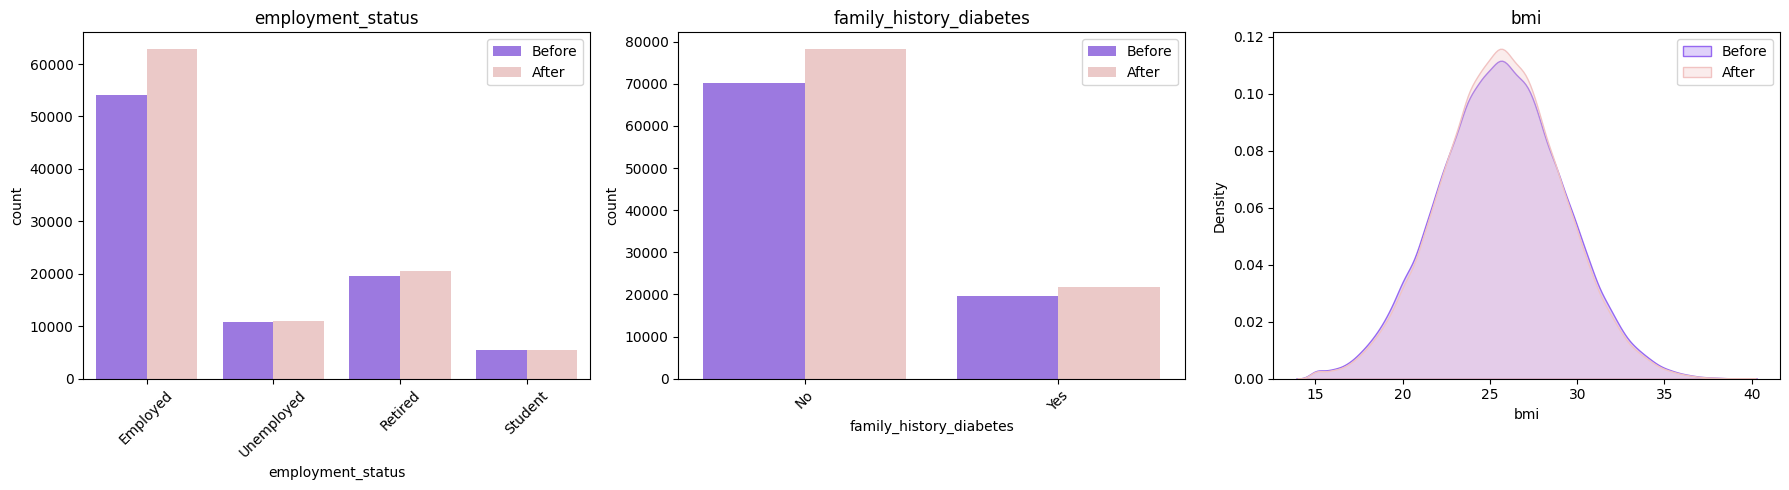

In [ ]:
# --- Compare variable distributions before and after imputation ---
# Define the variables to compare (both categorical and numerical)
variables = ['employment_status', 'family_history_diabetes', 'bmi']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(variables):
    if col in ['employment_status', 'family_history_diabetes']:
        # --- For categorical variables ---
         # Combine both datasets (before and after imputation)
        # Add a column 'dataset' to distinguish them in the plot
        combined = pd.concat([df_raw[[col]].assign(dataset='Before'),df_imputed[[col]].assign(dataset='After')], ignore_index=True)
        sns.countplot(x=col, hue='dataset', data=combined, ax=axes[i], palette=[palette_colors[-1], palette_colors[0]])
        axes[i].tick_params(axis='x', rotation=45)
    else:
        # --- For numerical variables ---
        # Plot kernel density estimates (KDE) for both datasets
        sns.kdeplot(df_raw[col], color=palette_colors[-1], label='Before', ax=axes[i], fill=True, alpha=0.3)
        sns.kdeplot(df_imputed[col], color=palette_colors[0], label='After', ax=axes[i], fill=True, alpha=0.3)
        axes[i].set_xlabel(col)

    axes[i].set_title(col)
    axes[i].legend()

plt.tight_layout()
plt.show()


## Correlations

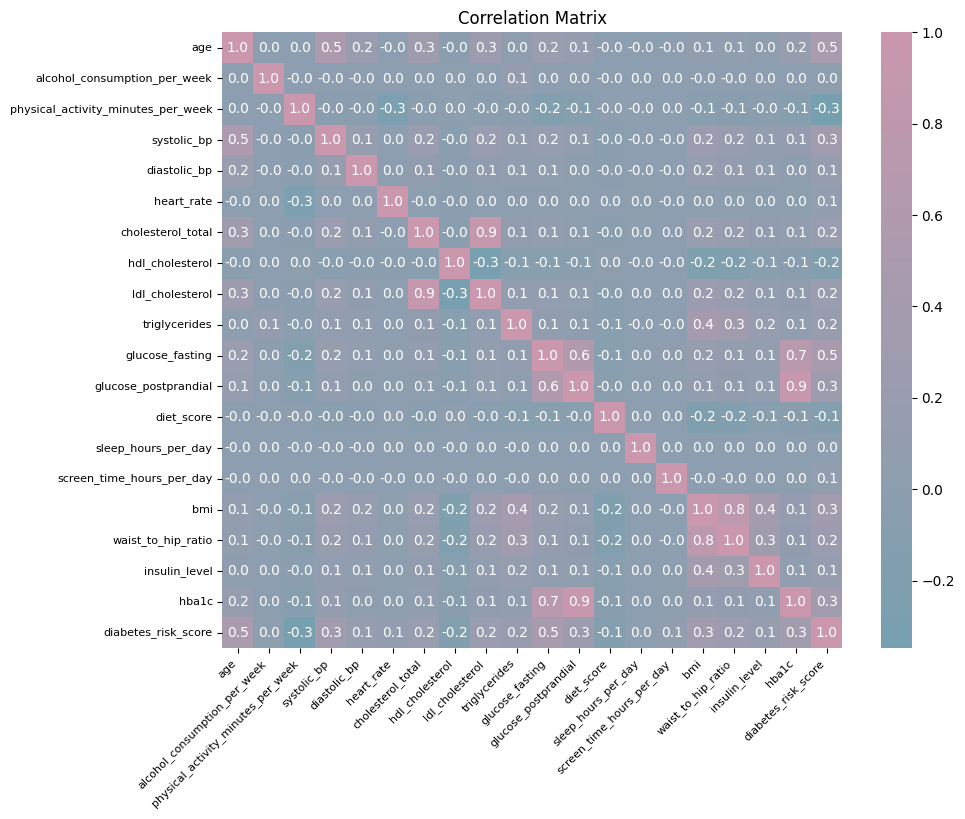

In [ ]:
num_cols = df_imputed_num.columns
cat_cols = categoric_features

# --- Correlation matrix between numerical variables ---
corr_matrix = df_imputed_num.corr()
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", ["#4EA5B1", "#CA97AD"])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap=custom_cmap, center=0)
plt.title("Correlation Matrix")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

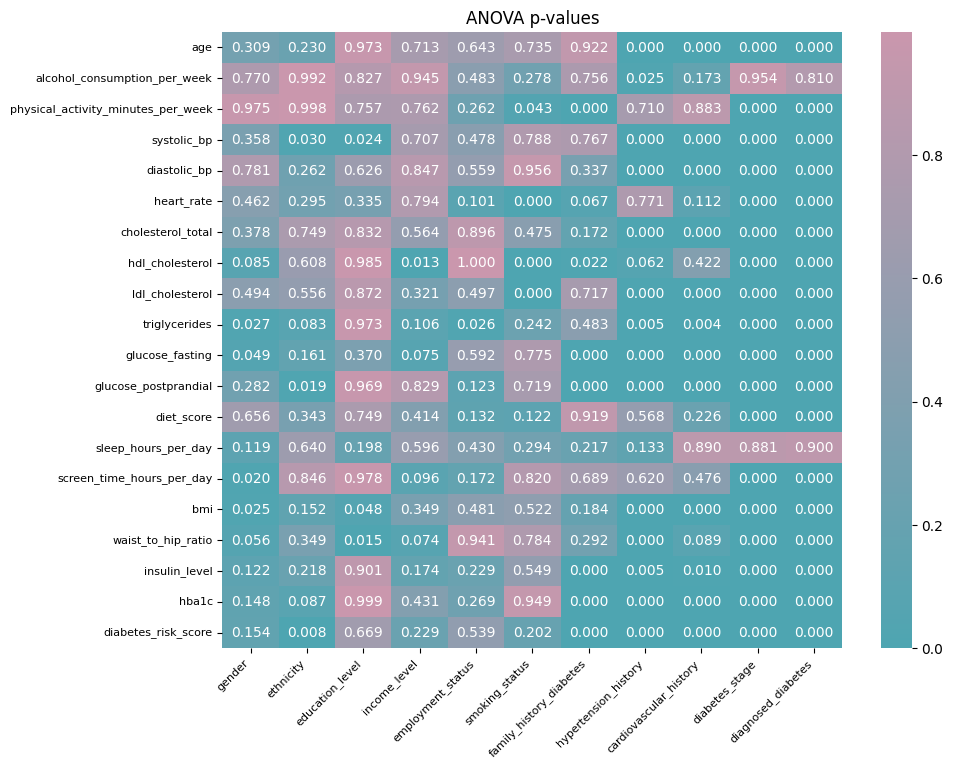

In [ ]:
# --- Perform ANOVA tests between numerical and categorical variables ---
anova_pvals = pd.DataFrame(index=num_cols, columns=cat_cols)

for num in num_cols:
    for cat in cat_cols:
        groups = [df_imputed[df_imputed[cat] == lvl][num] for lvl in df_imputed[cat].unique()]
        if len(groups) > 1:
            # Perform one-way ANOVA only if there are at least 2 different groups
            f_stat, p_val = f_oneway(*groups)
            anova_pvals.loc[num, cat] = p_val
        else:
            # If only one category exists, ANOVA cannot be computed
            anova_pvals.loc[num, cat] = np.nan
plt.figure(figsize=(10, 8))
sns.heatmap(anova_pvals.astype(float), annot=True, fmt=".3f", cmap=custom_cmap)
plt.title("ANOVA p-values")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

# If p-value < 0.05, there is a statistically significant relationship between the numeric
# and categorical variable. Their means differ across categories

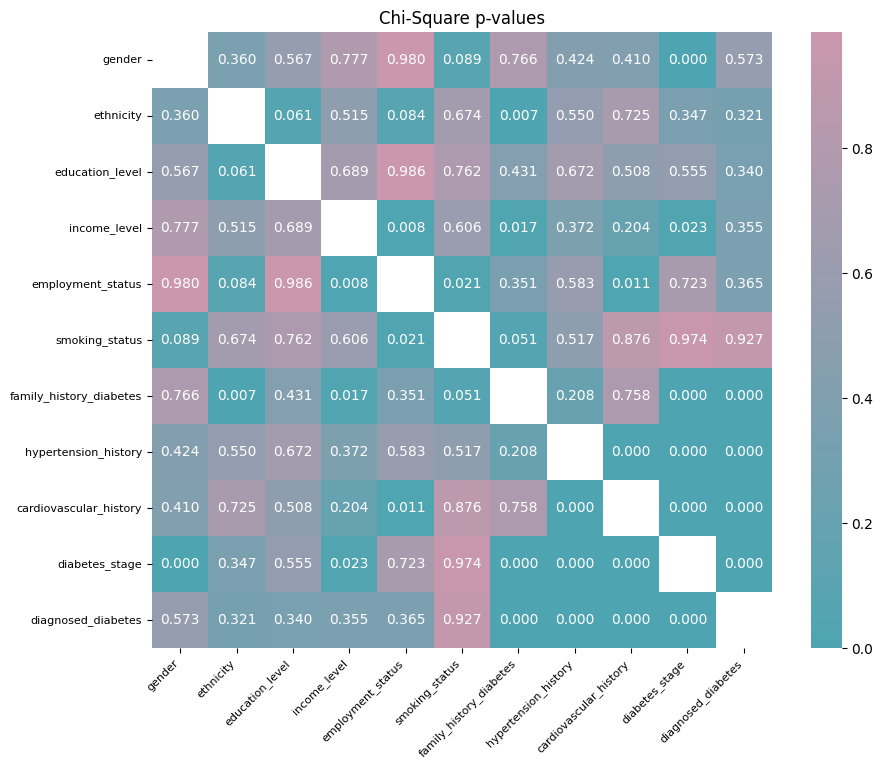

In [ ]:
# --- Perform Chi-square tests between pairs of categorical variables ---
chi2_pvals = pd.DataFrame(index=cat_cols, columns=cat_cols)

for cat1 in cat_cols:
    for cat2 in cat_cols:
        if cat1 == cat2:
            chi2_pvals.loc[cat1, cat2] = np.nan
        else:
            # Build a contingency table (cross-tabulation) of the two variables
            table = pd.crosstab(df_imputed[cat1], df_imputed[cat2])

            # Perform the Chi-square test of independence
            # H0: The two categorical variables are independent
            chi2, p, dof, ex = chi2_contingency(table)
            chi2_pvals.loc[cat1, cat2] = p

plt.figure(figsize=(10, 8))
sns.heatmap(chi2_pvals.astype(float), annot=True, fmt=".3f", cmap=custom_cmap)
plt.title("Chi-Square p-values")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

# If p-value < 0.05, the two categorical variables are likely related (not independent).

# PCA

In [ ]:
pca = PCA()
pca.fit(df_imputed_num)
X_pca = pca.transform(df_imputed_num)

In [ ]:
# Eigenvalues
eigenvalues = pca.explained_variance_

# Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative Variance
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Eigenvalues:", eigenvalues)
print("Explained Variance (%):", explained_variance_ratio * 100)
print("Cumulative Variance (%):", cumulative_variance * 100)

Eigenvalues: [3.68797799 2.21704893 1.75860567 1.33678904 1.27718233 1.05546228
 1.00826795 0.99798948 0.95379003 0.94115342 0.91454716 0.80554993
 0.7925019  0.67671802 0.53371858 0.40061795 0.28785119 0.2011247
 0.05453993 0.05021733]
Explained Variance (%): [18.48457287 11.11210603  8.81433532  6.70014153  6.40138579  5.29009923
  5.05355576  5.00203887  4.78050612  4.71716998  4.5838163   4.03750955
  3.97211133  3.3917891   2.67505936  2.00794359  1.44274348  1.00806028
  0.27336044  0.25169508]
Cumulative Variance (%): [ 18.48457287  29.5966789   38.41101423  45.11115575  51.51254154
  56.80264077  61.85619653  66.8582354   71.63874152  76.3559115
  80.93972779  84.97723734  88.94934867  92.34113777  95.01619712
  97.02414071  98.4668842   99.47494448  99.74830492 100.        ]


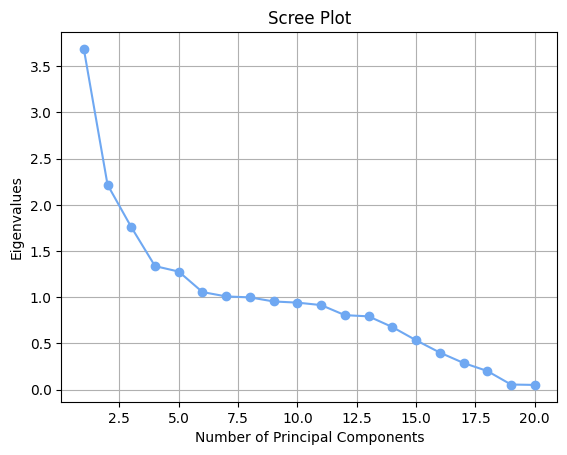

In [ ]:
# --- Scree Plot (Eigenvalues of PCA components) ---

plt.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o-', color="#6FA8F2")
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Eigenvalues')
plt.grid(True)
plt.show()

In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=df_imputed_num.columns
)
print(loadings)

                                         PC1       PC2       PC3       PC4  \
age                                 0.271887  0.043445  0.362508 -0.366811   
alcohol_consumption_per_week        0.011611  0.009543 -0.046245  0.009287   
physical_activity_minutes_per_week -0.116177  0.112591  0.077319  0.348947   
systolic_bp                         0.252341  0.110610  0.190156 -0.367744   
diastolic_bp                        0.125727  0.082051  0.038675 -0.215338   
heart_rate                          0.038748 -0.047342 -0.040250 -0.300927   
cholesterol_total                   0.252364  0.277669  0.426119  0.287630   
hdl_cholesterol                    -0.145517 -0.125301  0.045411 -0.220094   
ldl_cholesterol                     0.274458  0.296879  0.389692  0.344911   
triglycerides                       0.181504  0.166265 -0.297154  0.018456   
glucose_fasting                     0.326719 -0.369352 -0.012762  0.057209   
glucose_postprandial                0.289410 -0.462240 -0.030205

In [ ]:
def pca_biplot(pca, X_pca, feature_names, k_top=None, comp1=1, comp2=2):
    """
    Draws a PCA biplot showing both the projected data (scores) and variable loadings (arrows).

    Parameters
    ----------
    pca : sklearn.decomposition.PCA
    X_pca : The PCA-transformed data (scores)
    feature_names : Names of the original variables (for labeling arrows).
    k_top : If specified, only the top k variables (largest vector norms) are shown.
    comp1 : Index of the x-axis principal component.
    comp2 : Index of the y-axis principal component.
    """

    # --- Scores (projection of samples on selected PCs) ---
    xs = X_pca[:, 0]
    ys = X_pca[:, 1]

    # --- Loadings (variable contributions) ---
    # Each column of pca.components_.T corresponds to a variable.
    loadings = pca.components_.T[:, :2]

    # --- Scale loadings by sqrt of eigenvalues (Gabriel biplot scaling) ---
    scales = np.sqrt(pca.explained_variance_[:2])
    arrows = loadings * scales

    # --- Optionally select only top-k strongest variables ---
    if k_top is not None and k_top < arrows.shape[0]:
        strength = np.linalg.norm(arrows, axis=1)
        top_idx = np.argsort(strength)[-k_top:]
        arrows = arrows[top_idx]
        names = np.array(feature_names)[top_idx]
    else:
        names = np.array(feature_names)


    plt.figure(figsize=(7, 6))

    # --- Plot variable loadings as arrows ---
    for i, (x, y) in enumerate(arrows):
        plt.arrow(0, 0, x, y, head_width=0.01, head_length=0.01, length_includes_head=True, color="#6FA8F2")
        plt.text(x * 1.09, y * 1.09, names[i], fontsize=8)

    evr = pca.explained_variance_ratio_ * 100
    plt.xlabel(f'PC{comp1} ({evr[comp1-1]:.1f}%)')
    plt.ylabel(f'PC{comp2} ({evr[comp2-1]:.1f}%)')
    plt.title('PCA Biplot')
    plt.axhline(0, linewidth=0.8)
    plt.axvline(0, linewidth=0.8)
    plt.tight_layout()
    plt.show()

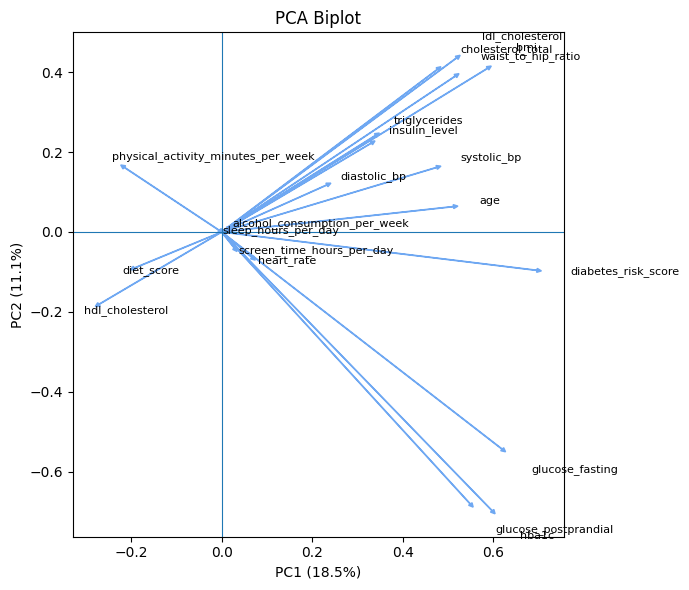

In [ ]:
pca_biplot(pca, X_pca, df_imputed_num.columns)

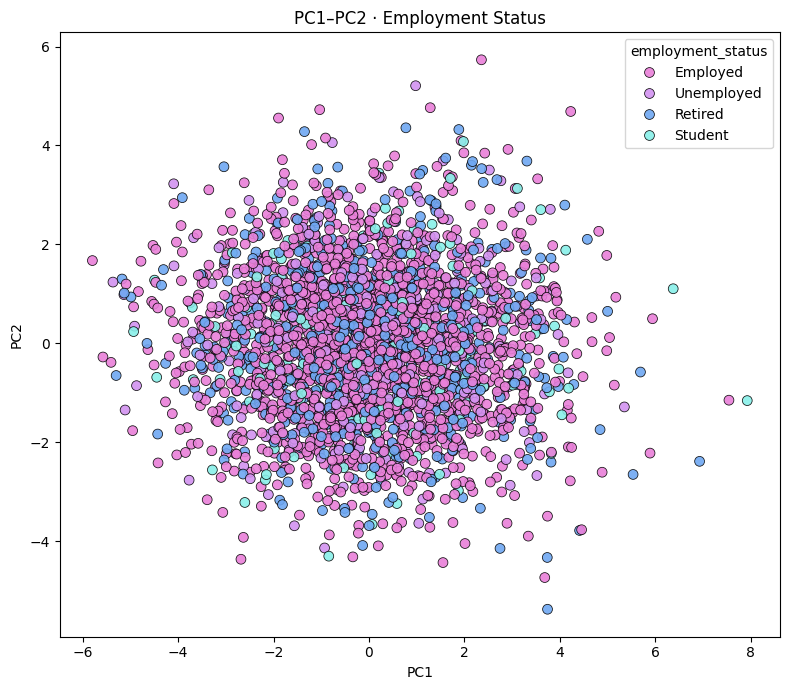

In [ ]:
# --- Visualize PCA scores colored by a categorical variable (employment_status) ---
df_plot = df_imputed.copy()
df_plot['PC1'] = X_pca[:, 0]
df_plot['PC2'] = X_pca[:, 1]

plt.figure(figsize=(8,7))
sns.scatterplot(
    data=df_plot.iloc[:3000],  # limit to 3000 points for clarity
    x='PC1', y='PC2',
    hue='employment_status',
    palette=[palette_colors[2], palette_colors[3], "#6FA8F2", "#88F0E9"],
    s=50, edgecolor='k', alpha=0.9
)
plt.title('PC1–PC2 · Employment Status')
plt.tight_layout()
plt.show()


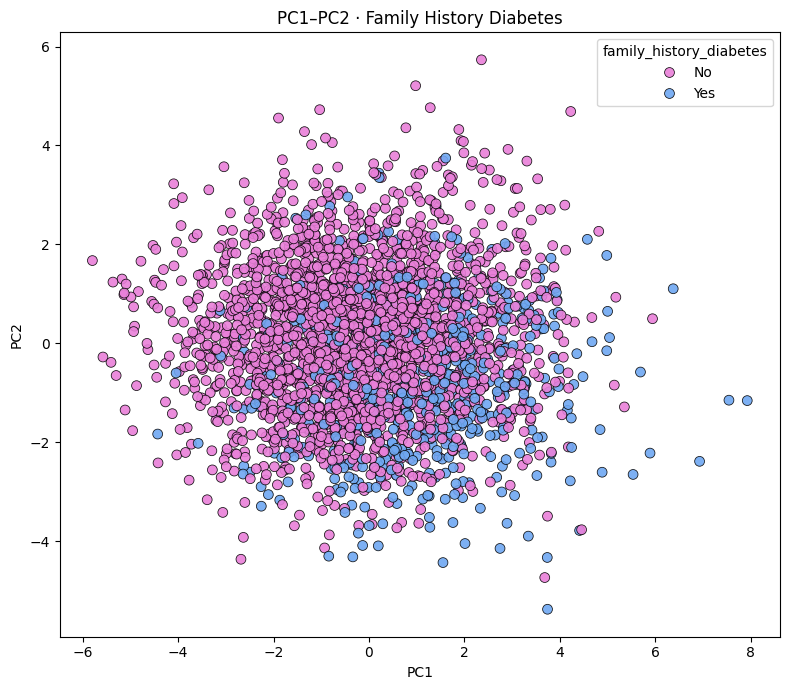

In [ ]:
# --- Visualize PCA scores colored by a categorical variable (family_history_diabetes) ---
plt.figure(figsize=(8,7))
sns.scatterplot(
    data=df_plot.iloc[:3000],  # limit to 3000 points for clarity
    x='PC1', y='PC2',
    hue='family_history_diabetes',
    palette=[palette_colors[2], "#6FA8F2"],
    s=50, edgecolor='k', alpha=0.9
)
plt.title('PC1–PC2 · Family History Diabetes')
plt.tight_layout()
plt.show()

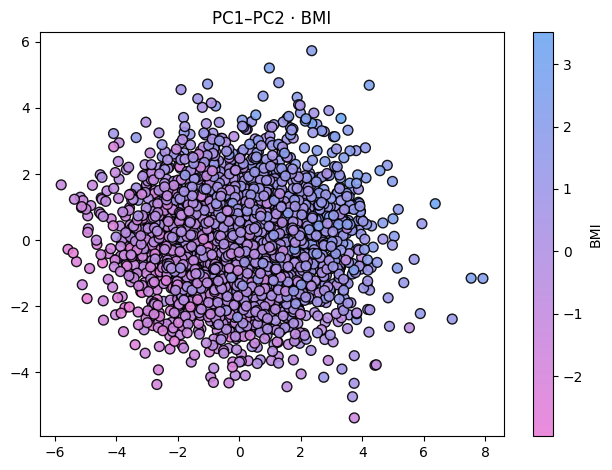

In [ ]:
# --- Visualize PCA scores colored by a numerical variable (BMI) ---
custom_cmap = LinearSegmentedColormap.from_list("my_cmap", [palette_colors[2], "#6FA8F2"])
sc = plt.scatter(
    X_pca[0:3000, 0], X_pca[0:3000, 1],
    c=df_imputed_num['bmi'][:3000],
    cmap=custom_cmap,
    s=50, alpha=0.9, edgecolors='k'
)
cbar = plt.colorbar(sc)
cbar.set_label('BMI')
plt.title('PC1–PC2 · BMI')
plt.tight_layout()
plt.show()